# Задание

В этой работе необходимо модель
 UNet используеть в качестве генератора, и создадить
отдельную модель-дискиминатор, а также реализовать алгоритм для
тренировки всей архитектуры conditional GAN. Обучить эту cGAN модель мы
будем на датасете MNIST содержащий изображения цифр, этот датасет
достаточно небольшой.
Сначала необходимо изменить UNet архитектуру, чтобы на вход модель
принимала шум — тензор размером 32, 32 и лэйбл (число от 0 до 9,
соответствующий классам в MNIST). Для этого:
- Размеры входного тензора для
сверток должен быть (input_batch_size, 1, 32, 32).
- Внутри функции форвард из лейбла сделаем тензор размером 32, 32 в
каждой ячейке которого будут это самое число. Для этого
воспользуйтесь функциями view() и repeat().
- Объединим шум и лэйбл с помощью concatenate
- Изменим первый UNetBlock так, чтобы он принимал тензор с двумя каналами

Обучить спроектированную генеративнцю модель на датасете MNIST,
содержащий изображения рукописных цифр. Загрузить его можно через
стандартные операции библиотеки torchvision.datasets.
Натренировать cGAN так, чтобы модель генерировала правдоподобные
цифры.

In [ ]:
import torch                 # Основная библиотека PyTorch для работы с тензорами и GPU
import torch.nn as nn        # Модуль для создания нейронных сетей и слоев
import torch.optim as optim  # Модуль с оптимизаторами для обучения моделей
from tqdm import tqdm        # Библиотека для отображения прогресс-бара в циклах
from torchvision import datasets #Подмодуль datasets содержит готовые датасеты и утилиты для их загрузки и обработки.

from torchvision import transforms            # Для преобразования и аугментации изображений
from torch.utils.data import DataLoader       # Для пакетной загрузки данных
import matplotlib.pyplot as plt                # Для визуализации изображений
import numpy as np                             # Для работы с массивами и преобразованиями
from torchvision.utils import make_grid       # Для создания сетки из изображений
import torch                                  # Основная библиотека PyTorch для тензоров и моделей


In [14]:

class UNetBlock(nn.Module):  # Определяем блок U-Net, наследуем от nn.Module (базовый класс нейросетей в PyTorch)
    def __init__(self, in_channels, out_channels):
        super(UNetBlock, self).__init__()  # Инициализация базового класса

        # Первый сверточный слой:
        # in_channels — число входных каналов (например, 3 для RGB),
        # out_channels — число выходных каналов (фильтров),
        # kernel_size=3 — размер фильтра 3x3,
        # padding=1 — c добавлением пикселей на границе. Для сохранения рахмеров изображения.
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)

        self.bn1 = nn.BatchNorm2d(out_channels)
        # Создаём слой пакетной нормализации (Batch Normalization) для 2D данных (например, изображений)
        # out_channels — количество каналов (фильтров) на выходе сверточного слоя, для которых будет рассчитана нормализация

        # Что делает BatchNorm2d:
        # - Нормализует активации (выходы предыдущего слоя) по каждому каналу отдельно
        # - Вычисляет среднее и стандартное отклонение по батчу и пространственным измерениям (высота, ширина)
        # - Приводит значения к нулевому среднему и единичному отклонению, затем масштабирует и сдвигает их с помощью обучаемых параметров
        # - Помогает стабилизировать и ускорить обучение нейросети, снижая внутреннее смещение распределения активаций

        # Функция активации ReLU:
        # inplace=True — изменяет данные на месте без создания нового объекта (экономит память)
        self.relu = nn.ReLU(inplace=True)

        # Второй сверточный слой:
        # in_channels и out_channels равны out_channels первого слоя,
        # kernel_size и padding аналогичны первому,
        # каждый сверточный слой — отдельный слой с собственными весами
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

        self.bn2 = nn.BatchNorm2d(out_channels)
        # Операция максимального объединения (max pooling):
        # kernel_size=2 — берет максимум из каждой области 2x2,
        # stride=2 — сдвигается на 2 пикселя, уменьшая размер изображения вдвое по ширине и высоте
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        # Прямой проход данных через блок

        x = self.conv1(x)  # Проходим через первую свертку
        x = self.bn1(x)   # Применяем слой нормализации
        x = self.relu(x)   # Применяем ReLU — обнуляем отрицательные значения
        x = self.conv2(x)  # Проходим через вторую свертку
        x = self.bn2(x)   # Применяем слой нормализации
        x = self.relu(x)   # Снова ReLU

        pooled = self.pool(x)  # Применяем max pooling, уменьшая размер

        # Возвращаем два значения:
        # x — результат после двух сверток (будет использоваться для пропуска (skip connection) в U-Net),
        # pooled — уменьшенная версия для следующего уровня сети
        return x, pooled


class UNetUpBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNetUpBlock, self).__init__()
        # nn.ConvTranspose2d - транспонированная свертка, используется для увеличения пространственных размеров (upsampling).
        # Параметры:
        # in_channels - количество входных каналов,
        # out_channels - количество выходных каналов,
        # kernel_size=2 - размер ядра свертки 2x2,
        # stride=2 - шаг 2 для удвоения размера входа (например, 64x64 -> 128x128).
        self.upconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

        # nn.Conv2d - обычная 2D-свертка для извлечения признаков.
        # Параметры:
        # in_channels - количество входных каналов,
        # out_channels - количество выходных каналов,
        # kernel_size=3 - размер ядра 3x3,
        # padding=1 — c добавлением пикселей на границе. Для сохранения рахмеров изображения.
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)

        # Создаём слой пакетной нормализации (Batch Normalization) для 2D данных (например, изображений)
        self.bn1 = nn.BatchNorm2d(out_channels)


        # nn.ReLU - функция активации ReLU (Rectified Linear Unit),
        # inplace=True означает, что операция делается "на месте" для экономии памяти.
        self.relu = nn.ReLU(inplace=True)

        # Второй сверточный слой с теми же параметрами, для более глубокого извлечения признаков.
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

        # Создаём слой пакетной нормализации (Batch Normalization) для 2D данных (например, изображений)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x, skip_connection):
        # x - входной тензор (например, из предыдущего слоя U-Net, с уменьшенным пространственным размером).
        # skip_connection - тензор из соответствующего слоя вниз по U-Net, для объединения деталей.

        # Применяем транспонированную свертку для увеличения размера изображения (upsampling).
        x = self.upconv(x)

        # Объединяем (конкатенируем) по канальному измерению (dim=1)
        # upsampled x и skip_connection, чтобы сохранить детали из ранних слоев.
        x = torch.cat([x, skip_connection], dim=1)

        # Пропускаем результат через первый сверточный слой для извлечения признаков.
        x = self.conv1(x)
        # Применяем слой нормализации
        x = self.bn1(x)
        # Применяем активацию ReLU для нелинейности.
        x = self.relu(x)

        # Пропускаем через второй сверточный слой для более детальной обработки.
        x = self.conv2(x)

        # Применяем слой нормализации
        x = self.bn2(x)

        # Снова ReLU активация.
        x = self.relu(x)

        # Возвращаем обработанный тензор.
        return x




In [15]:
class UNetGenerator(nn.Module):
    def __init__(self, num_classes=10):
        super(UNetGenerator, self).__init__()
        # Определяем энкодерные блоки UNet, которые последовательно уменьшают размер признаков и увеличивают глубину
        self.enc1 = UNetBlock(2, 64)   # Первый блок принимает 2 канала (например, шум + метка)
        self.enc2 = UNetBlock(64, 128) # Второй блок: 64 входных каналов, 128 выходных
        self.enc3 = UNetBlock(128, 256)
        self.enc4 = UNetBlock(256, 512)
        # "Боттлнек" — самая глубокая часть сети с 1024 каналами
        self.bottleneck = UNetBlock(512, 1024)
        # Декодерные блоки UNet для восстановления пространственного разрешения, используя skip connections
        self.up4 = UNetUpBlock(1024, 512)
        self.up3 = UNetUpBlock(512, 256)
        self.up2 = UNetUpBlock(256, 128)
        self.up1 = UNetUpBlock(128, 64)
        # Финальный сверточный слой, который сводит число каналов к 1 — например, для бинарной сегментации
        self.final_conv = nn.Conv2d(64, 1, kernel_size=1)
    def forward(self, noise, labels):
        # noise — тензор входного шума (например, случайный вектор или карта)
        # labels — тензор с метками классов для условного моделирования
        # Расширяем labels до карты признаков того же размера, что и шум, добавляя новые оси:
        # labels.view(-1, 1, 1, 1) — изменяем размер до (batch_size, 1, 1, 1)
        # repeat(1, 1, 32, 32) — копируем по высоте и ширине (32, 32), чтобы получить карту 32, 32
        label_map = labels.view(-1, 1, 1, 1).repeat(1, 1, 32, 32)
        # Конкатенируем (объединяем) по канальному измерению (1) шум и карту меток
        x = torch.cat((noise, label_map), 1)

        # Проходим через энкодерные блоки UNet
        # Каждый блок возвращает два значения: x_i — выход блока, p_i — пуллинговый выход для следующего слоя
        x1, p1 = self.enc1.forward(x)
        x2, p2 = self.enc2.forward(p1)
        x3, p3 = self.enc3.forward(p2)
        x4, p4 = self.enc4.forward(p3)

        # Пропускаем через "боттлнек" — глубинный сверточный блок без пуллинга
        x5, _ = self.bottleneck.forward(p4)

        # Проход через декодерные блоки с пропускными связями (skip connections)
        # Каждый блок объединяет вход с соответствующим выходом энкодера для восстановления деталей
        x = self.up4.forward(x5, x4)
        x = self.up3.forward(x, x3)
        x = self.up2.forward(x, x2)
        x = self.up1.forward(x, x1)

        # Финальный сверточный слой для получения результата сегментации или карты признаков
        x = self.final_conv(x)

        return x


In [16]:
# Создаем экземпляр модели UNetGenerator с параметром по умолчанию num_classes=10
def create_model(model = UNetGenerator()):
    # Создаем тензор шума с размерностью (1, 1, 32, 32):
    # 1 — batch size (один пример в пакете),
    # 1 — число каналов (например, один канал шума),
    # 32x32 — пространственное разрешение.
    img_noise = torch.randn(1, 1, 32, 32)  # случайный шум с нормальным распределением

    # Создаем тензор меток labels размером (1,) с единственным значением 0
    labels = torch.tensor([0])  # метка класса для условного генератора


    # Передаем шум и метку в модель — вызывается метод forward()
    output = model(img_noise, labels)

    # Выводим размерность выходного тензора
    print(output.shape)

    # Ожидаемый результат:
    # torch.Size([1, 1, 32, 32])
    # Это значит, что модель выдала одно изображение с одним каналом и размером 32x32 пикселя

In [17]:
create_model()

torch.Size([1, 1, 32, 32])



Нужно создать модель дискриминатор, которая
принимает на вход изображение и лэйбл, а на выходе имеет бинарную
классификацию, фейк или не фейк. Дискриминатор должен состоять из:
1. 4 комбинации (conv (3x3, padding = 1) + max_pool (2x2, stride = 2)+ relu)
2. В каждой операции свертки увеличивайте количество фильтров/выходных
каналов: 64, 128, 256, 512
3. Замыкать архитектуру должен полносвязный слой с функцией активации
сигмоида. Перед ним необходимо будет развернуть feature_map в
одномерный тензор. Посчитайте количество входных значений для
полносвязного слоя, при условии, что на вход подаются изображения
размером 32*32, на выходе должно быть только одно значение.


In [18]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # Первый сверточный слой: принимает 2 канала (например, изображение + карта меток)
        # kernel_size=3 — размер свёрточного ядра 3x3
        # stride=1 — шаг свёртки равен 1
        # padding=1 — добавляем 1 пиксель с каждой стороны для сохранения размера входа
        self.conv1 = nn.Conv2d(2, 64, kernel_size=3, stride=1, padding=1)
        # MaxPooling уменьшает пространственные размеры в 2 раза, kernel=2, stride=2
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Второй сверточный блок: 64 входных, 128 выходных каналов
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        # Третий сверточный блок: 128 -> 256 каналов
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Четвертый сверточный блок: 256 -> 512 каналов
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Полносвязный слой: вход 512*2*2 (после 4 раз понижения размера), выход 1 (вероятность реальности)
        self.fc = nn.Linear(512 * 2 * 2, 1)

    def forward(self, img, labels):
        # img — входное изображение (или сгенерированное), размер (batch, 1, 32, 32)
        # labels — тензор с метками классов (batch,)

        # Создаем карту меток размером 28x28, чтобы объединить с изображением
        label_map = labels.view(-1, 1, 1, 1).repeat(1, 1, 32, 32)

        # Объединяем изображение и карту меток по канальному измерению (dim=1)
        d_in = torch.cat((img, label_map), 1)  # теперь размер (batch, 2, 32, 32)

        # Пропускаем через первый сверточный слой и применяем ReLU активацию
        x = nn.ReLU(inplace=True)(self.conv1(d_in))
        x = self.pool1(x)  # уменьшаем размер до 16x16

        x = nn.ReLU(inplace=True)(self.conv2(x))
        x = self.pool2(x)  # уменьшаем размер до 8x8

        x = nn.ReLU(inplace=True)(self.conv3(x))
        x = self.pool3(x)  # уменьшаем размер до 4x4

        x = nn.ReLU(inplace=True)(self.conv4(x))
        x = self.pool4(x)  # уменьшаем размер до 2x2

        # "Выпрямляем" тензор в вектор для подачи в полносвязный слой
        x = x.view(x.size(0), -1)  # размер (batch, 512*2*2)

        # Полносвязный слой + сигмоида для получения вероятности [0,1]
        x = torch.sigmoid(self.fc(x))
        return x


In [19]:
create_model(model=Discriminator())

torch.Size([1, 1])


In [20]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [21]:

# Функция для тренировки GAN — генератора и дискриминатора
def train_gan(generator, discriminator, train_loader, num_epochs=50, lr=0.0002):
    images = []  # Список для хранения сгенерированных изображений в процессе обучения

    # Функция потерь для бинарной классификации — измеряет разницу между предсказаниями и метками
    criterion = nn.BCELoss()

    # Оптимизаторы Adam для генератора и дискриминатора
    # lr — скорость обучения
    # betas — параметры для адаптивного момента градиента (стандартные значения для GAN)
    optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(num_epochs):  # Цикл по эпохам
        # tqdm — индикатор прогресса обучения по батчам
        for real_images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            real_images = real_images.to(device)  # Переносим реальные изображения на устройство (CPU/GPU)
            labels = labels.to(device)            # Переносим метки классов на устройство

            batch_size = real_images.size(0)     # Размер батча

            # Создаем тензоры с метками для дискриминатора:
            real_labels = torch.ones(batch_size, 1).to(device)  # Метки "1" для реальных изображений
            fake_labels = torch.zeros(batch_size, 1).to(device) # Метки "0" для сгенерированных изображений

            # --- Обучение дискриминатора ---

            # Шаг 1: создаем случайный шум для генератора
            noise = torch.randn(batch_size, 1, 32, 32).to(device)
            # Генерируем фейковые изображения с помощью генератора
            fake_images = generator(noise, labels)

            # Шаг 2: дискриминатор оценивает реальные изображения
            outputs_real = discriminator(real_images, labels)
            # И оценивает фейковые изображения (detach отключает градиенты для fake_images, чтобы не обновлять генератор)
            outputs_fake = discriminator(fake_images.detach(), labels)

            # Шаг 3: считаем потери дискриминатора на реальных и фейковых данных
            d_loss_real = criterion(outputs_real, real_labels)  # Потеря на реальных
            d_loss_fake = criterion(outputs_fake, fake_labels)  # Потеря на фейковых

            d_loss = d_loss_real + d_loss_fake  # Общая потеря дискриминатора

            # Обнуляем градиенты перед обратным распространением ошибки
            optimizer_D.zero_grad()
            d_loss.backward()  # Вычисляем градиенты для дискриминатора
            optimizer_D.step() # Обновляем веса дискриминатора

            # --- Обучение генератора ---

            # Генератор хочет обмануть дискриминатор, чтобы тот считал фейковые изображения за реальные
            outputs = discriminator(fake_images, labels)
            # Потеря генератора рассчитывается с "реальными" метками, т.к. цель — "заставить" дискриминатор ошибиться
            g_loss = criterion(outputs, real_labels)

            optimizer_G.zero_grad()
            g_loss.backward()  # Вычисляем градиенты для генератора
            optimizer_G.step() # Обновляем веса генератора

        # Сохраняем пример сгенерированных изображений для визуализации прогресса
        # Генерируем 10 примеров шума размером (10, 1, 32, 32)
        sample_noise = torch.randn(10, 1, 32, 32).to(device)
        # Создаем тензор меток с классами от 0 до 9 для условного генератора
        sample_labels = torch.tensor([i for i in range(10)]).to(device)
        # Передаем шум и метки в генератор, чтобы получить сгенерированные изображения
        sample_images = generator(noise=sample_noise, labels=sample_labels)
        # Отключаем вычисление градиентов, переносим результат на CPU и сохраняем в список images
        images.append(sample_images.detach().cpu())


        # Выводим статистику по эпохе
        print(f"Epoch [{epoch+1}/{num_epochs}], d_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}, D(x): {outputs_real.mean().item():.4f}, D(G(z)): {outputs_fake.mean().item():.4f}")

    return images  # Возвращаем список сгенерированных изображений по эпохам


In [22]:

# Создаем последовательность преобразований для изображений:
transform = transforms.Compose([
    transforms.Resize((32, 32)),               # Изменяем размер изображений MNIST на 32, 32 пикселя
    transforms.ToTensor(),                      # Преобразуем PIL Image или ndarray в тензор PyTorch (значения в [0,1])
    transforms.Normalize([0.5], [0.5])         # Нормализуем тензор: (x - 0.5) / 0.5 → значения в диапазоне [-1,1]
])

# Загружаем тренировочный датасет MNIST с указанными преобразованиями
train_dataset = datasets.MNIST(
    root='./data',                             # Папка для хранения данных
    train=True,                               # Загружаем тренировочную часть
    download=True,                            # Скачиваем, если данных нет локально
    transform=transform                       # Применяем последовательность преобразований к каждому изображению
)

# Создаем загрузчик данных (DataLoader) для пакетной обработки и перемешивания
train_loader = DataLoader(
    train_dataset,
    batch_size=64,                           # Размер пакета (batch size) — 64 изображения за итерацию
    shuffle=True                            # Перемешиваем данные на каждой эпохе
)


In [23]:

# Функция для визуализации изображений в виде сетки
def show_images(images, num_images=10, nrow=5):
    # Берем первые num_images изображений
    images = images[:num_images]
    # Создаем сетку изображений с nrow изображениями в строке, нормализуем для корректного отображения
    images = make_grid(images, nrow=nrow, normalize=True)
    # Преобразуем тензор в numpy-массив
    npimg = images.numpy()
    plt.figure(figsize=(8, 8))
    # plt.imshow ожидает каналы в последнем измерении, поэтому меняем оси
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')  # Убираем оси
    plt.show()

# Функция для генерации и отображения изображений с помощью генератора
def generate_images(generator):
    generator.eval()  # Переводим модель в режим оценки (выключаем дропаут и нормализацию батча)
    # Создаем пакет шума для 10 изображений размером 32, 32 с 1 каналом
    noise = torch.randn(10, 1, 32, 32).to(device)
    # Создаем метки для цифр от 0 до 9
    labels = torch.tensor([i for i in range(10)]).to(device)
    with torch.no_grad():  # Отключаем вычисление градиентов, чтобы сэкономить память и время
        fake_images = generator(noise, labels)  # Генерируем изображения
    # Отображаем сгенерированные изображения, переводя их на CPU и удаляя вычислительный граф
    show_images(fake_images.cpu().data, num_images=10)



Epoch 1/10: 100%|██████████| 938/938 [00:45<00:00, 20.67it/s]


Epoch [1/10], d_loss: 1.0828, g_loss: 1.5381, D(x): 0.5789, D(G(z)): 0.3725


Epoch 2/10: 100%|██████████| 938/938 [00:44<00:00, 20.99it/s]


Epoch [2/10], d_loss: 0.8947, g_loss: 1.4660, D(x): 0.6402, D(G(z)): 0.2230


Epoch 3/10: 100%|██████████| 938/938 [00:44<00:00, 20.90it/s]


Epoch [3/10], d_loss: 0.5204, g_loss: 2.4431, D(x): 0.7474, D(G(z)): 0.1217


Epoch 4/10: 100%|██████████| 938/938 [00:44<00:00, 20.91it/s]


Epoch [4/10], d_loss: 0.9585, g_loss: 2.5124, D(x): 0.7375, D(G(z)): 0.3651


Epoch 5/10: 100%|██████████| 938/938 [00:44<00:00, 20.94it/s]


Epoch [5/10], d_loss: 0.6902, g_loss: 1.8783, D(x): 0.6648, D(G(z)): 0.1667


Epoch 6/10: 100%|██████████| 938/938 [00:44<00:00, 20.90it/s]


Epoch [6/10], d_loss: 0.7168, g_loss: 2.2894, D(x): 0.7364, D(G(z)): 0.1892


Epoch 7/10: 100%|██████████| 938/938 [00:44<00:00, 20.95it/s]


Epoch [7/10], d_loss: 0.9609, g_loss: 2.3887, D(x): 0.6927, D(G(z)): 0.3474


Epoch 8/10: 100%|██████████| 938/938 [00:44<00:00, 20.90it/s]


Epoch [8/10], d_loss: 1.0451, g_loss: 1.4961, D(x): 0.6131, D(G(z)): 0.2529


Epoch 9/10: 100%|██████████| 938/938 [00:44<00:00, 20.94it/s]


Epoch [9/10], d_loss: 1.4569, g_loss: 1.9262, D(x): 0.4216, D(G(z)): 0.1415


Epoch 10/10: 100%|██████████| 938/938 [00:44<00:00, 20.94it/s]

Epoch [10/10], d_loss: 0.9182, g_loss: 1.1902, D(x): 0.5486, D(G(z)): 0.1782


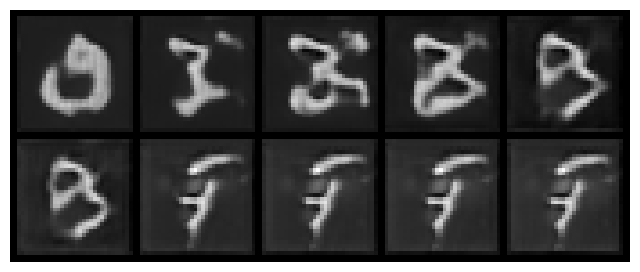

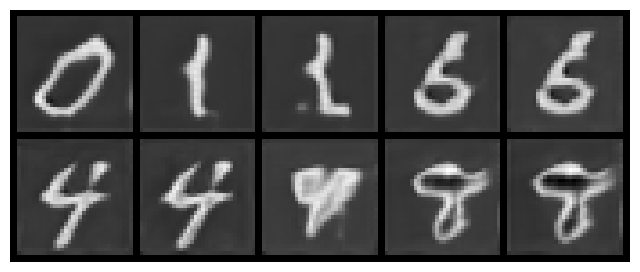

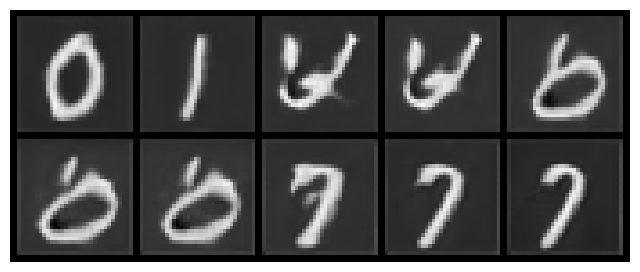

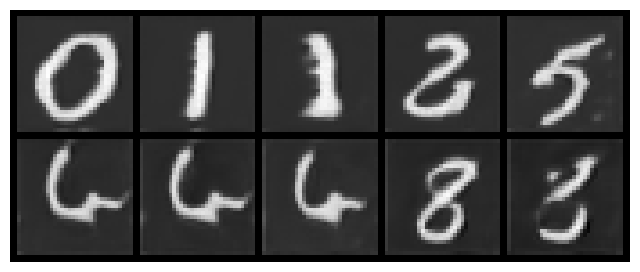

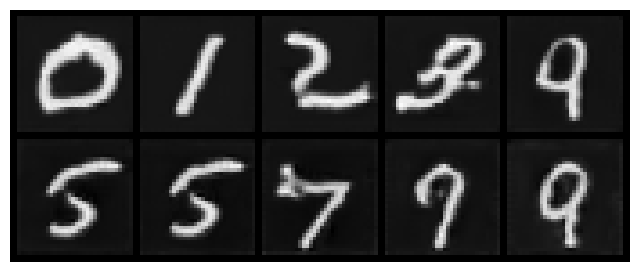

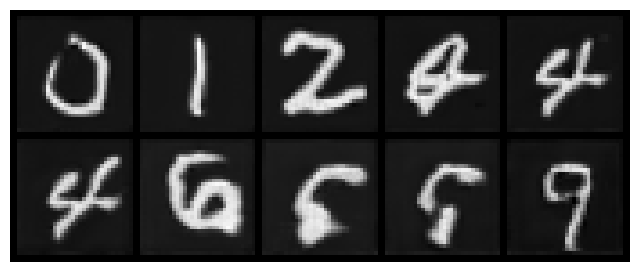

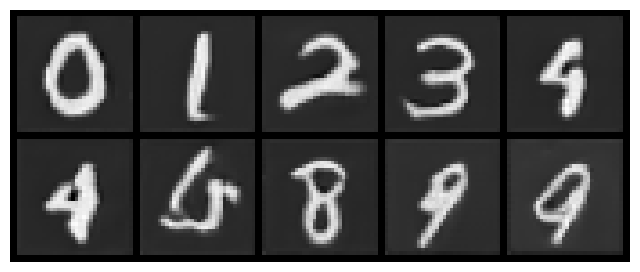

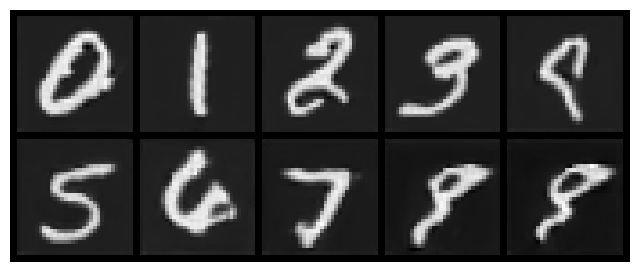

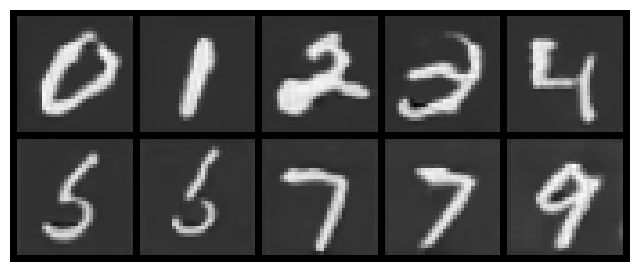

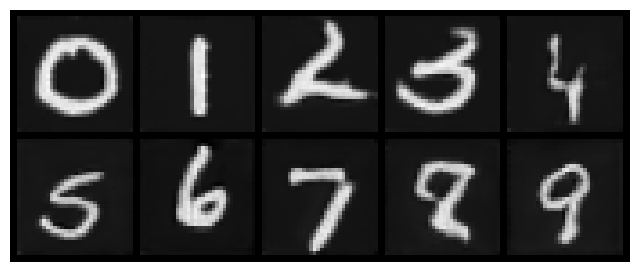

In [24]:

# Создаем загрузчик данных с размером пакета 64 и перемешиванием данных
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Инициализируем модели генератора и дискриминатора и переносим их на выбранное устройство (CPU или GPU)
generator = UNetGenerator().to(device)
discriminator = Discriminator().to(device)

# Запускаем обучение GAN на 10 эпох с заданной скоростью обучения
images = train_gan(generator, discriminator, train_loader, num_epochs=10, lr=0.0002)

# Визуализируем сгенерированные изображения, сохранённые в процессе тренировки
for image_set in images:
    show_images(image_set.cpu(), num_images=10, nrow=5)

# Вывод

Был построен условный генератор conditional GAN на базе U-Net, принимающий шум и метки классов, и создающий изображения цифр.

Дискриминатор принимает изображение и метку, объединённые по каналам, и учится отличать реальные и сгенерированные изображения.

Используется байесовская кросс-энтропия (BCE loss) для обучения обеих моделей.

В тренировке генератора и дискриминатора реализован классический GAN-цикл с оптимизацией через Adam.

Для работы с изображениями реализованы удобные функции для визуализации и подготовки данных.

Также, входные данные нормализуются из [0,1] в [-1,1] для лучшей сходимости.

Используются условные метки, расширенные до пространственной размерности, что позволяет управлять генерацией по классам.

Общая архитектура и обучение соответствуют стандартам современных conditional GAN.